# DMR-Gene Correlation

Calculate the partial correlation between DMR and Genes using clusters/samples as features.

## Import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.mcds import RegionDS
from ALLCools.mcds.correlation import region_correlation, get_corr_table

## Load Data

In [2]:
# DMR data
dmr = RegionDS.open('../RegionDS/test_HIP/')

# gene data
gene = RegionDS.open('test_HIP_Cluster/', region_dim='geneslop2k')

Using dmr as region_dim


In [3]:
# global mC fractions, calculated from cell level MCDS by sum up cluster and genome base calls
sample_mch = gene.get_coords('sample_CHN')
sample_mcg = gene.get_coords('sample_CGN')

### DMR Input

A 2-D sample-by-DMR DataArray, values are mCG fractions

In [4]:
data_a = dmr['dmr_da_frac'].transpose('sample', 'dmr')
data_a

<xarray.DataArray 'dmr_da_frac' (sample: 20, dmr: 131)>
array([[0.538462, 0.816129, 0.70068 , ..., 0.144186, 0.340136, 0.292444],
       [0.717949, 0.97006 , 0.922078, ..., 0.03    , 0.142259, 0.249802],
       [0.717949, 0.974227, 0.886179, ..., 0.011628, 0.085575, 0.196755],
       ...,
       [0.888889, 0.670588, 0.038462, ..., 0.55    , 0.25974 , 0.621951],
       [0.857143, 0.727823, 0.666667, ..., 0.295455, 0.562387, 0.544554],
       [0.777778, 0.780822, 0.5625  , ..., 0.0625  , 0.297297, 0.292553]],
      dtype=float32)
Coordinates:
  * dmr         (dmr) <U9 'chr1-0' 'chr1-1' 'chr1-2' ... 'chr19-121' 'chr19-122'
    dmr_chrom   (dmr) <U5 'chr1' 'chr1' 'chr1' ... 'chr19' 'chr19' 'chr19'
    dmr_end     (dmr) int64 10002172 10003542 10003967 ... 5099203 5099952
    dmr_length  (dmr) int64 2 305 54 2 2 2 10 ... 589 924 632 842 195 399 335
    dmr_ndms    (dmr) int64 1 7 2 1 1 1 2 13 3 2 1 ... 2 1 2 7 13 19 8 8 3 6 13
    dmr_start   (dmr) int64 10002170 10003237 10003913 ... 5098804 5099617
  * sample      (sample) <U18 'snm3C_ASC' 'snm3C_CA1' ... 'snmC_ODC' 'snmC_OPC'

### Gene Input

A 2-D sample-by-gene DataArray, values are cluster-normalized mCH fractions

In [5]:
data_b = gene.sel(
    mc_type='CHN',
    sample=data_a.get_index('sample'))['geneslop2k_da_frac'].transpose(
        'sample', 'geneslop2k')
data_b

<xarray.DataArray 'geneslop2k_da_frac' (sample: 20, geneslop2k: 55487)>
[1109740 values with dtype=float64]
Coordinates:
    mc_type           <U3 'CHN'
  * sample            (sample) object 'snm3C_ASC' 'snm3C_CA1' ... 'snmC_OPC'
    sample_CGN        (sample) float64 0.7203 0.7387 0.7422 ... 0.7434 0.7196
    sample_CHN        (sample) float64 0.007835 0.02362 ... 0.01121 0.005743
    strand_type       <U4 'both'
  * geneslop2k        (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSMUSG...
    geneslop2k_chrom  (geneslop2k) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM'
    geneslop2k_end    (geneslop2k) int64 3076321 3104124 3673497 ... 16299 16299
    geneslop2k_start  (geneslop2k) int64 3071252 3100015 3203900 ... 13288 13355

## Calculate correlations between DMR and genes

In [6]:
true_results, null_results = region_correlation(data_a,
                                                data_b,
                                                sample_mch,
                                                sample_mcg,
                                                method='pearson',
                                                max_dist=1000000,
                                                cpu=40,
                                                null='sample',
                                                null_n=100000)

Using dmr as region_dim
Using dmr_start and dmr_end to calculate pos
Using geneslop2k as region_dim
Using geneslop2k_start and geneslop2k_end to calculate pos
Calculating chr1
Calculating chr19


In [7]:
true_results.X.data.size, null_results.size

(19100, 19100)

### Plot correlation distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


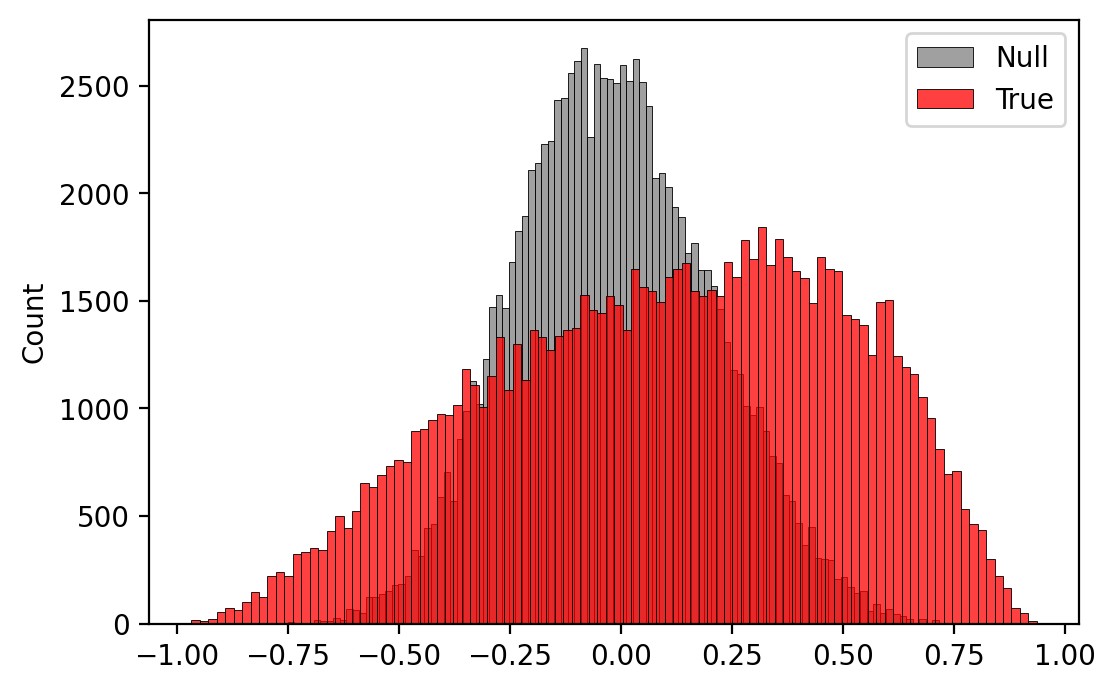

In [8]:
import numpy as np

fig, ax = plt.subplots(dpi=200)
sns.histplot(ax=ax,
             data=np.random.choice(null_results, 100000),
             label='Null',
             bins=100,
             color='grey')
sns.histplot(ax=ax,
             data=np.random.choice(true_results.X.data, 100000),
             label='True',
             bins=100,
             color='red')
ax.legend()

## Get Significantly Correlated Pairs

In [9]:
corr_table = get_corr_table(true_results,
                            null_results,
                            region_dim_a=data_a.dims[1],
                            region_dim_b=data_b.dims[1],
                            direction='+',
                            alpha=0.03)

corr_table['pair_distance'] = corr_table['dmr_pos'] - corr_table['geneslop2k_pos']

corr_table

Correlation cutoff corr > 0.5499999999999998
2855 correlation pairs selected.


,dmr,geneslop2k,corr,dmr_pos,geneslop2k_pos,pair_distance
0,chr1-0,ENSMUSG00000025916.10,0.688226,10002171,9988879,13292
1,chr1-2,ENSMUSG00000102871.1,0.653428,10003940,9288550,715390
2,chr1-3,ENSMUSG00000067851.11,0.602079,10005478,10185119,-179641
3,chr1-3,ENSMUSG00000098234.7,0.560595,10005478,9943037,62441
4,chr1-3,ENSMUSG00000045210.8,0.701606,10005478,9733501,271977
...,...,...,...,...,...,...
2850,chr19-122,ENSMUSG00000024835.15,0.678979,5099784,4151326,948458
2851,chr19-122,ENSMUSG00000044724.9,0.811770,5099784,4142762,957022
2852,chr19-122,ENSMUSG00000024842.8,0.749665,5099784,4139727,960057
2853,chr19-122,ENSMUSG00000024845.17,0.655735,5099784,4129119,970665


### Plot distance and correlation distribution

<AxesSubplot:xlabel='pair_distance', ylabel='Count'>

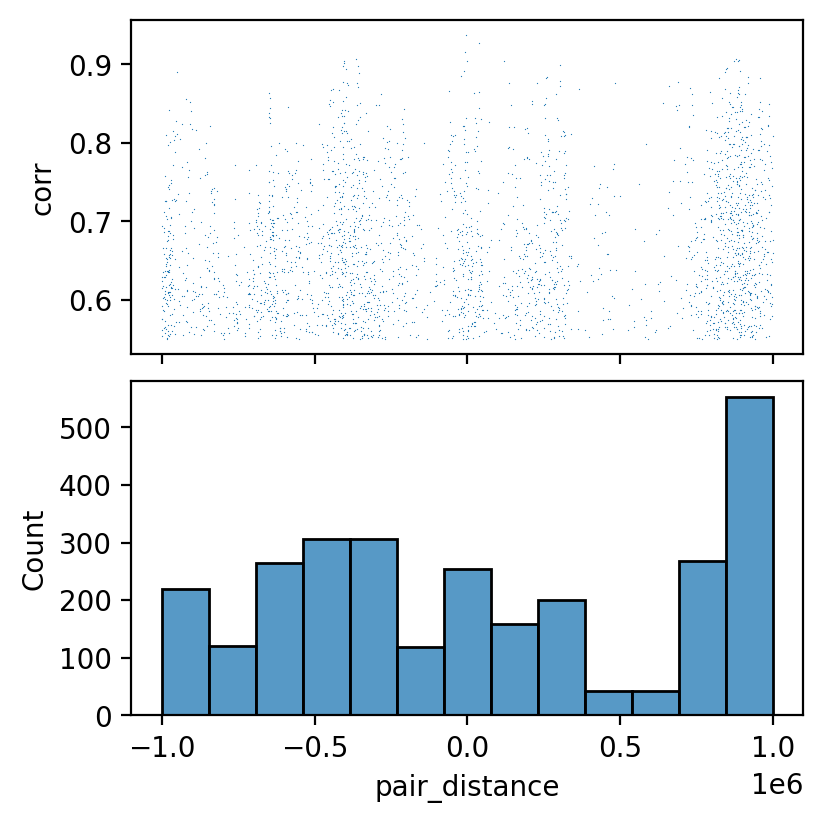

In [10]:
fig, axes = plt.subplots(figsize=(4, 4), nrows=2, dpi=200, constrained_layout=True, sharex=True)

ax = axes[0]
sns.scatterplot(ax=ax,
                data=corr_table,
                x='pair_distance',
                y='corr',
                s=0.2,
                linewidth=0)
ax = axes[1]
sns.histplot(corr_table['pair_distance'], ax=ax)